In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'ytick.labelsize' :20,
         'xtick.labelsize' :20,
         'legend.fontsize': 15,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 15
         }
plt.rcParams.update(params)
plt.style.use('science')

figure_folder = 'C://Users//Admin//Desktop//lab_optique//data//optique_non_lineaire'

## Semaine 1: 
Les différentes expériences de cette semaine incluent: 
1) Mesures de la loi de Malus
2) Mesures du spectre $I$ vs $\lambda$ du laser autour de 1064 nm (avec un courant dans la pompe $I_p$ constant)
3) Mesures du rapport $\frac{I_{max}(1064 \text{nm})}{I_{max}(\text{808 nm})}$ en fonction du courant dans la pompe. 


#### Loi de Malus. 

La loi de Malus relie l'intensité d'une onde polarisée linéairement d'intensité $I_0 = \sqrt{E_0}$ à l'intensité $I$ de l'onde après son passage dans un polariseur linéaire parfait orienté selon un angle $\theta - \phi$ par rapport au plan de propagation de l'onde. Mathématiquement, on a 
$$
I(\theta) = I_0 \cos^2(\theta - \phi) \, .
$$
Durant l'expérience, on mesurait seulement $\theta$, l'angle de polarisation du polariseur par rapport à la verticale. Cependant, la loi de Malus s'applique pour **l'angle de polarisation entre le polariseur et la direction de polarisation du laser** et on doit introduire le déphasage $\phi$. Il nous faut donc ajuster deux paramètres, $I_0$ et $\phi$. 

Parlons d'incertitudes avant de commencer le code. On utilise la plus demie-mesure de la plus petite graduation de notre instrument de mesure pour l'angle, donc $\sigma_\theta \sim 2$ degrés. Pour I, on prend une vingtaine de mesures au même angle en réinitialisant le set up expérimental à chaque fois et on mesure l'écart type de cet ensemble de mesures. 

Petit calcul pour "rendre la loi de Malus linéaire": 
$$
\begin{align}
\cos^2(\theta - \phi)&=\frac{1 + \cos\left(2(\theta - \phi)\right)}{2}
\\
&=\frac{1}{2} + \frac{1}{2}\cos(2(\theta - \phi))
\\
&=\frac{1}{2} + \frac{1}{2}\left[\cos(2\theta)\cos(2\phi) + \sin(2 \theta)\sin(2 \phi) \right]
\\
&= \frac{1}{2} + \beta_1\cos(2\theta) +\beta_2 \sin(2 \theta) 
\end{align}
$$
On peut donc réécrire la loi de Malus de manière linéaire comme 
$$
I(\theta) = \beta_0 + \beta_1 \cos(2 \theta) + \beta_2 \sin(2\theta)
$$
où les $\beta_i$ sont les paramètres à ajuster avec 
$$
\begin{align}
\beta_0 = \frac{I_0}{2} &\rightarrow I_0 = 2 \beta_0
\\
\beta_1 = \frac{I_0}{2} \cos(2\phi) &\rightarrow \phi = \frac{1}{2}\arccos(\beta_1/\beta_0)
\\
\beta_2 = \frac{I_0}{2}\sin(2\phi) &\rightarrow \phi = -\frac{1}{2}\arcsin(\beta_2/\beta_0)
\\
\frac{\beta_2}{\beta_1}= \tan(2 \phi) &\rightarrow \phi = \frac{1}{2}\arctan(\beta_2/\beta_1)
\end{align}
$$

À l'issue de la régression linéaire, on a des incertitudes sur les paramètres ajustées $\beta_i$. On utilise donc la formule de propagation des incertitudes pour retrouver les incertitudes sur les variables physiques $I_0$ et $\phi$.
$$
\begin{align}
I_0 &= 2 \beta_0 \\
\sigma_{I_0} &=|\frac{\partial I_0}{\partial \beta_0}\sigma_{\beta_0}|=2 \sigma_{\beta_0}\\
\phi &= \frac{1}{2} \arctan\left( \frac{\beta_2}{\beta_1}\right)
\\
\frac{\partial \phi}{\partial \beta_2} &= \frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} 
\\
\frac{\partial \phi}{\partial \beta_1} &= -\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} 
\\
\sigma_\phi &= \sqrt{\left( \frac{\partial \phi}{\partial \beta_1}\right)^2\sigma_{\beta_1}^2 + \left( \frac{\partial \phi}{\partial \beta_2}\right)^2\sigma_{\beta_2}^2} 
\\
&= \sqrt{\left(\frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_1}^2 + \left(\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_2}^2}
\\
&= \frac{1}{2(\beta_1^2 + \beta_2^2)}\sqrt{\beta_1^2\sigma_{\beta_1}^2 + \beta_2 \sigma_{\beta_2}^2}
\end{align}
$$

Dernière équation ici. On va également avoir une incertitude sur l'intensité prédite par la loi de Malus en propageant les incertitudes une dernière fois. 
$$
\begin{align}
\sigma_{I} &= \sqrt{\left( \frac{\partial I}{\partial I_0}\right)^2\sigma_{I_0}^2 + 
\left( \frac{\partial I}{\partial \theta}\right)^2\sigma_{\theta}^2
+
\left( \frac{\partial I}{\partial \phi}\right)^2\sigma_{\phi}^2}
\\
&= \sqrt{\cos^2(\theta-\phi)\sigma_{I_0}^2  + 4 I_0^2\sin^2(\theta-\phi)\cos^2(\theta-\phi)\sigma_{\phi}^2+4 I_0^2\sin^2(\theta-\phi)\cos^2(\theta-\phi)\sigma_{\theta}^2}
\end{align}
$$

Note: De manière équivalente, on peut faire passer les valeurs $(I_{0}, \theta, \phi)$ perturbées par les déviations standards $(\sigma_{I_{0}},\sigma_{\theta}, \sigma_{\phi})$ puis les faire passer dans la loi de Malus afin de propager les incertitudes. Cette méthode implique moins de maths (mais la précédente constitue une belle dérivation!).

In [6]:
def malus_law(theta, I0, phi):
    return I0 * np.cos(theta - phi) ** 2

def fit_params_to_phys_params(param1, param2, param3): 
    return np.array([2 * param1, 0.5 * np.arctan(param3 / param2)])

def std_params_to_std_physical(params, stds): 
    """
    Must take as input the combination (value, std)

    Args:
        pair1 (Tuple): _description_
        pair2 (Tuple): _description_
        pair3 (Tuple): _description_
    """
    sigma_intensity_fitted = 2 * stds[0]

    beta1, beta2 = params[1:]
    sigma_beta1 = stds[1]
    sigma_beta2 = stds[2]
    sigma_phi_fitted = 1 / (beta1 ** 2 + beta2 ** 2) * np.sqrt(beta1 ** 2 * sigma_beta1 ** 2 + beta2 ** 2 * sigma_beta2 ** 2)
    return np.array([sigma_intensity_fitted, sigma_phi_fitted])

def std_malus(theta, phys_fitted, phys_std, std_theta):
    I0, phi = phys_fitted
    std_intensity, std_phi = phys_std
    return np.sqrt(np.cos(theta - phi) ** 2 * std_intensity ** 2  + (2 * I0 * np.sin(theta - phi) * np.cos(theta - phi)) ** 2 * (std_phi ** 2 + std_theta ** 2))

In [7]:
# Importation des valeurs expérimentales mesurées 
theta = np.arange(20, 361, 20) * u.degree.to(u.radian)  # rad
sigma_theta = 2 * u.degree.to(u.radian) # rad
intensity_20 = np.array([0.007,  0.0073, 0.0072,0.00702, 0.00713, 0.00612, 0.00625, 0.00618, 0.0064]) # series of measurements at theta=20 radians
intensity = np.array([intensity_20.mean(), 0.01000, 0.00842, 0.00527, 0.00186, 0.00023, 0.00049, 0.00275, 0.0053, 0.00835, 0.00920, 0.00770, 0.00520, 0.00200, 0.0002, 0.00049, 0.0026, 0.00590]) # mA
sigma_intensity = intensity_20.std(ddof = 1)

# Régression linéaire (voir code dans src/regression.py)
Regression = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_intensity
)

# Créer la 'design matrix' de régression
Regression.design_matrix = np.column_stack([np.ones_like(theta),  np.cos(2 * theta), np.sin(2 * theta)])

# Calcul des paramètres beta_i optimaux
params_fitted, std_fitted = Regression.fit(
    obs = intensity, 
    x = None, 
    ridge_reg = 1e-9, 
    fit_intercept = True
)

# Conversion des paramètres de régression ajustées aux paramèteres physiques d'intérêt (ici, l'intensité initiale du faisceau et le déphasage)
phys_fitted = fit_params_to_phys_params(*params_fitted) 
phys_std = std_params_to_std_physical(params = params_fitted, stds = std_fitted)# incertitude sur paramètre physique
intensity_fitted, phi_fitted = phys_fitted
intensity_pred = malus_law(theta, *phys_fitted) # intensity predicted by adjusting our physical model on data 
norm_residuals =  (intensity - intensity_pred) / sigma_intensity 
chi2 = Regression.compute_chi2(obs = intensity)

print(f"Intensité initiale du laser: {phys_fitted[0] * 1e3:.2f} +/- {phys_std[0]* 1e3:.2f} micro-amperes")
print(f"Déphasage: {phys_fitted[1] *u.radian.to(u.degree):.0f} +/- {phys_std[1]*u.radian.to(u.degree):.0f} degrees")
print(chi2)
print(Regression.cov)

Intensité initiale du laser: 9.19 +/- 0.23 micro-amperes
Déphasage: 39 +/- 2 degrees
1.022764447656902
[[ 1.30319444e-08 -1.44799383e-18 -1.44799473e-18]
 [-1.44799383e-18  2.60638889e-08 -2.89598887e-18]
 [-1.44799473e-18 -2.89598887e-18  2.60638889e-08]]


ValueError: 'x' and 'y' must have the same size

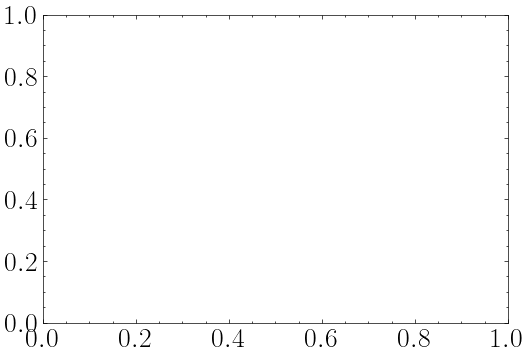

In [110]:
from matplotlib.ticker import MultipleLocator
# Première figure: Intensité versus angle 
fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs

# Afficher mesures avec erreurs
x = theta - phi_fitted # tableau de valeurs axe des x
ax.errorbar(x = x, 
            y = intensity * 1e3, 
            xerr = sigma_theta, 
            yerr = sigma_intensity * 1e3, 
            fmt = '.', 
            elinewidth=1.5, 
            label = 'Mesures', 
            color = 'midnightblue'
            )

# Afficher prédiction du model 
x_range = np.array([-np.pi / 4, 2 * np.pi])
x_fit =  np.linspace(x_range.min(), x_range.max()-phi_fitted + 0.2, 100)
intensity_fitted = malus_law(x_fit + phi_fitted, *phys_fitted)
ax.plot(x_fit, intensity_fitted * 1e3, "green", label = 'Régression linéaire')

# Afficher incertitudes sur la régression linéaire
std_intensity = np.sqrt(std_malus(theta = x_fit + phi_fitted, phys_fitted = phys_fitted, phys_std = phys_std, std_theta=sigma_theta) **2 + sigma_intensity ** 2)

# Beautiful uncertainty zones 
k1 = 1
ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted - k1 * std_intensity) * 1e3, 
    y2 = (intensity_fitted + k1 * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.5, 
    label = r'Incertitudes'
    )
k2 = 2
ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted - k1 * std_intensity -1e-5) * 1e3, 
    y2 = (intensity_fitted - (k2) * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.3
    )

ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted + k1 * std_intensity +1e-5) * 1e3, 
    y2 = (intensity_fitted + (k2) * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.3
    )
# Rendre la figure plus jolie :) 
ax.set(xlabel = r"$(\theta-\phi_{fit})$[rad]", ylabel = r"$I$[$\mu$A]", xlim = [-1, 6.], ylim = [-2, 18])
x_ticks = np.arange(0, 5, np.pi/2)
x_tick_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"]
ax.xaxis.set_ticks(x_ticks)
ax.xaxis.set_ticklabels(x_tick_labels)

ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.05, 0.85), xycoords = 'axes fraction', color = 'r', fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig(os.path.join(figure_folder, 'figure_malus.pdf'), bbox_inches = 'tight')
# maj_ticks = 

(array([ 1.,  0.,  4., 11.,  2.]),
 array([-3.07211272, -2.12111694, -1.17012116, -0.21912538,  0.73187039,
         1.68286617]),
 <BarContainer object of 5 artists>)

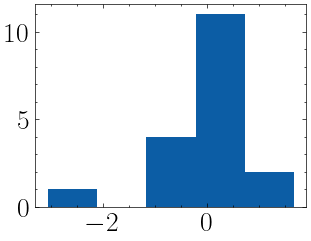

In [9]:
plt.hist(norm_residuals, bins = 5)

### Calcul de la largeur spectrale du pic d'émission du laser 
Commençons par importer les données et puis par estimer l'incertitude sur le 'counts' mesuré par le spectromètre

In [10]:
def import_data(filename):
    wavelength = []
    intensity = []
    with open(filename, "r") as f: 
        lines = f.readlines()
        lines = lines[17:-1]
        for line in lines:
            line = line.strip()
            line = line.split("\t")
            wavelength.append(float(line[0].replace(",", "."))) # counts 
            intensity.append(float(line[1].replace(",", "."))) # nanometers 
    return np.array(wavelength), np.array(intensity)

def get_window(wavelength, intensity, wavelength_center = 1064, extent = 50):
    """
    Get a slice of the wavelength data and the intensity data around a specific wavelength
    """
    idx_center = np.argmin(abs(wavelength - wavelength_center))
    D, U = idx_center - extent, idx_center + extent
    return wavelength[D:U], intensity[D:U]


In [11]:
from glob import glob
from tqdm import tqdm 
pattern = "450_std*.txt"
std_files = glob(os.path.join(figure_folder, pattern))

std_file = std_files[0]
wavelength = []
intensity = []

low_center = 808 #nm
high_center = 1064 #nm
multiple_intensity_peaks = np.empty(shape = (len(std_files), 2))

for i, std_file in tqdm(enumerate(std_files)):
    wavelength, intensity = import_data(filename = std_file)

    wavelength_low, intensity_low = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = low_center, 
                                            extent = 500) 

    wavelength_high, intensity_high = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = high_center, 
                                            extent = 500) 
    multiple_intensity_peaks[i] = np.array([intensity_low.max(), intensity_high.max()])


10it [00:00, 41.52it/s]


In [12]:
sigma_wavelength = 10 # nm (donnée par Arthur)
sigma_intensity = multiple_intensity_peaks.std(axis = 0, ddof = 1).max() # 

Le bruit de l'instrument semble varier avec l'intensité (ou peut-être la longueur d'onde?)... Puisque nous n'avons pas accès à la fonction de réponse du spectromètre selon la longueur d'onde, faisons pour l'instant l'hypothèse d'un bruit constant.

On peut maintenant importer les données pour le fit de la Gaussienne.

1261.1457154605264


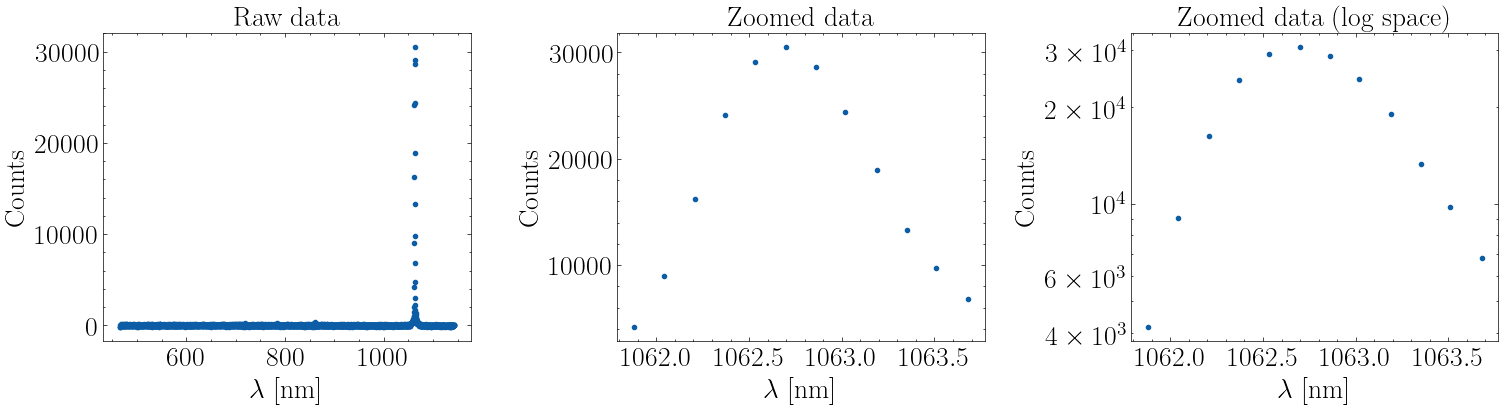

In [13]:
filename = os.path.join(figure_folder, "spectral_width_low_counts.txt")

wavelength_full, intensity_full = import_data(filename = filename)
print(intensity.mean())
high_center = 1062.9
wavelength_window, intensity_window = get_window(wavelength = wavelength_full, 
                                            intensity = intensity_full, 
                                            wavelength_center = high_center, 
                                            extent = 6) 

# Calcul d'ordonnée à l'origine à retirer (bruit ambiant)
wavelength_window_noise, intensity_window_noise = get_window(wavelength = wavelength_full, 
                                            intensity = intensity_full, 
                                            wavelength_center = 700, 
                                            extent = 1000)
offset = intensity_window_noise.mean()
std = intensity_window_noise.std() 

nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize = (6 * ncols, 4 * nrows))

ax = axs[0]
ax.plot(wavelength_full, intensity_full-offset, ".")
ax.set_title("Raw data")


ax = axs[1]
ax.plot(wavelength_window, intensity_window-offset, ".")
ax.set_title("Zoomed data")


ax = axs[2]
ax.plot(wavelength_window, intensity_window-offset, ".")
ax.set_title("Zoomed data (log space)")
ax.set_yscale("log")

for ax in axs: 
    ax.set(xlabel = r"$\lambda$ [nm]", ylabel= r"Counts")
plt.subplots_adjust(wspace=0.4)

# Selection d'une portion des données pour la suite
wavelength = wavelength_window
intensity = intensity_window 

On veut maintenant faire une régression linéaire sur une Gaussienne. L'astuce ici est de faire la régression dans l'espace logarithmique. L'intensité (en termes de comptes) est ici définie comme 
$$
\begin{align}
I(\lambda) = I_{0} \exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\end{align}
$$
où $\lambda_{0}$ est la moyenne de la Gaussienne (là où le pic d'émission du laser est censé se situer)

On peut maintenant appliquer le log
$$
\begin{align}
\ln I (\lambda)&= -\frac{(\lambda - \lambda_0)^2}{2w^2} + \ln(I_0)
\\
&= -\frac{1}{2w^2} \left(\lambda^2 - 2 \lambda \lambda_{0} +\lambda_{0}^2\right) + \ln(I_0)
\\
&= \underbrace{-\frac{1}{2w^2}}_{\beta_0} \lambda^2 + \underbrace{\frac{\lambda_0}{w^2}}_{\beta_1} \lambda - \underbrace{\frac{\lambda_{0}^{2}}{2w^2} + \ln(I_0)}_{\beta_2}
\\
&= \beta_2 + \beta_1 \lambda + \beta_0 \lambda^2 
\end{align}
$$

On isole maintenant les variables $\lambda_0, w, I_0$ à partir des paramètres de la régression linéaire
$$
\begin{align}
w^2 &= -\frac{1}{2 \beta_0} \Longrightarrow  \sigma_{w^2} = \frac{1}{2 \beta_0^2} \sigma_{\beta_0}
\\
\lambda_0 &= w^2 \beta_1 =-\frac{\beta_1}{2 \beta_0}\Longrightarrow \sigma_{\lambda_0} = \sqrt{\beta_1^2 \sigma_{w^2}^2 + (w^2)^2 \sigma_{\beta_1}^2} 
\\
\beta_2 &= -\frac{\lambda_0^2}{2w^2} + \ln(I_0) \Longrightarrow \lambda_0^2=\frac{\beta_1^2}{4\beta_0^2} \Longrightarrow \frac{\lambda_0^2}{2w^2}=-\frac{\beta_1^2}{4\beta_0} 
\\
I_0 &= e^{\beta_2+\frac{\lambda_0^2}{2w^2}} = 
\exp\left( 
    \beta_2 + \frac{\lambda_0^2}{2w^2}
\right) 
\Longrightarrow 
\sigma_{I_0} = \exp\left( 
    \beta_2 + \frac{\lambda_0^2}{2w^2}
\right) \sqrt{
    \sigma_{\beta_{2}}^2 
    + 
    \frac{\lambda_{0}^2}{(w^2)^2}\sigma_{\lambda_0}^2
    + 
    \frac{\lambda_0^4}{4(w^2)^4}\sigma_{w^2}^2
    }
\end{align}
$$

Finalement, il faut propager les incertitudes en espace logarithmique: 
$$
\sigma_{\ln(I)} = \Biggr \lvert \frac{\partial \ln(I)}{\partial I} \Biggr \rvert  \sigma_I= \frac{\sigma_{I}}{I} \, .
$$

Ici, on semble un peu embêté aux premiers abords afin d'inclure l'incertitude sur $\ln(I)$; l'incertitude dépend de l'intensité elle-même et n'est pas constante ! La solution (fréquentiste) est de minimiser le "weighted chi squared", ou le poids est défini comme $w(I)=\frac{1}{\sigma^{2}_{\ln(I)}}$. Une version de la régression pondérée (qui a une solution analytique) est implémentée dans l'objet `FrequentistRegression` avec la méthode `wfit`. 

In [14]:
def gaussian_profile(wavelength, I0, wavelength_center, width): 
    I = I0 * np.exp( -(wavelength - wavelength_center) ** 2 / (2 * width) ** 2)
    return I

def params_to_phys(params, std_params): 
    beta0, beta1, beta2 = params
    std_beta0, std_beta1, std_beta2 = std_params
    var = -1 / (2 * beta2)
    mu = - beta1 / (2 * beta2)
    A = np.exp(beta0 + mu ** 2 / (2 * var))

    std_var = std_beta2 / (2 * beta2 ** 2)
    # std_mu = np.sqrt(var ** 2 * std_beta1 ** 2 + std_var ** 2 * beta1 ** 2)
    std_mu = np.sqrt( (std_beta1 / (2 * beta2)) ** 2 + (beta1 * std_beta2 / (2*beta2 ** 2))**2)
    std_A = A * np.sqrt(std_beta0 ** 2 + mu ** 2 / (var) ** 2 * std_mu ** 2 + std_var ** 2 * (mu / var) ** 4)
    return np.array([A, mu, var]), np.array([std_A, std_mu, std_var])


def compute_fwhm(sigma): 
    """
    Compute the FWHM of a Gaussian from its standard deviation
    """
    return 2 * np.sqrt(2 * np.log(2)) * sigma

In [15]:
Regression_width = FrequentistRegression(
    degree = 2,
    sigma_noise = (sigma_intensity)/intensity,
) 

params_fitted, std_fitted = Regression_width.wfit(
    obs = np.log(intensity), 
    x = wavelength, 
    ridge_reg = 0, 
    fit_intercept = True
)

chi2 = Regression_width.compute_chi2(
    obs = np.log(intensity)
)
print( "chi", chi2)

phys_fitted, phys_std = params_to_phys(params_fitted, std_fitted)
pred_intensity_log = Regression_width.forward_model()

print(phys_fitted)
print(phys_std)
print(Regression_width.cov)

chi 3.472013195198997
[3.48902714e+04 1.06274075e+03 2.73844086e-01]
[3.79204627e+10 2.19694622e+02 4.00285764e-02]
[[ 9.08779763e+10 -1.71017555e+08  8.04567893e+04]
 [-1.71017554e+08  3.21827208e+05 -1.51406592e+02]
 [ 8.04567891e+04 -1.51406592e+02  7.12306379e-02]]


WoW ! Les incertitudes sont plutôt grandes ! La raison est que la matrice de Covariance a des éléments hors de la diagonale très grand, par conséquent nous ne pouvons pas utiliser la formule usuelle de propagation des incertitudes. A la place, je propose ici un moyen rapide de calculer la covariance sur les paramètres physiques en utilisant jax et l'autodifférentiation. 

In [17]:
!pip install jax 

  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 28.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.3 MB ? eta -:--:--
   -------- ------------------------------- 12.1/56.3 MB 58.1 MB/s eta 0:00:01
   ---------------- ----------------------- 23.1/56.3 MB 54.0 MB/s eta 0:00:01
   ------------------------- -------------- 36.4/56.3 MB 56.5 MB/s eta 0:00:01
   ---------------------------------- ----- 48.5/56.3 MB 57.1 MB/s eta 0:00:01
   ---------------------------------------  56.1/56.3 MB 56.7 MB/s eta 0:00:01
   ---------------------------------------- 56.3/56.3 MB 49.1 MB/s eta 0:00:00
Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)


In [18]:
import jax.numpy as jnp
from jax import jacfwd



def params_to_phys(beta):
    beta_0, beta_1, beta_2 = beta
    sigma_squared = -1 / (2 * beta_2)
    mu = -beta_1 / (2 * beta_2)
    print()
    A = jnp.exp( beta_0 +(mu**2) / (2 * sigma_squared))
    return jnp.array([A, mu, sigma_squared])

cov = Regression_width.cov
jacobian = jacfwd(params_to_phys)(params_fitted)
eigvals = jnp.linalg.eigvals(cov)
epsilon = 5e-8  # Small regularization term for the covariance
cov_regularized = cov + epsilon * np.eye(cov.shape[0])
var = np.sqrt(np.diag(np.array(jacobian @ cov_regularized @ jacobian.T)))

print(params_to_phys(params_fitted))
print(var)



[3.4890254e+04 1.0627407e+03 2.7384409e-01]
[9.8202870e+06 1.4490485e-01 4.0028591e-02]


C'est un peu mieux mais on a encore un problème pour l'amplitude de la Gaussienne... En fait, cet effet semble être du au fait que l'on a un petit nombre de points ici (l'effet est reproduit sur des données simulées dans le notebook `frequentist_vs_bayesian_regression.ipynb`). Essayons de voir ce qui se passe avec une autre méthode. 

In [19]:
from scipy.optimize import curve_fit

parameters_fitted, cov = curve_fit(gaussian_profile, wavelength, intensity)
print(parameters_fitted)
print(cov)

[1. 1. 1.]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_26872\3019345568.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters_fitted, cov = curve_fit(gaussian_profile, wavelength, intensity)


`curve_fit` semble avoir le même problème à la différence qu'il ne parvient pas à obtenir les paramètres de régression optimaux (en même temps nous lui donnons une exponentielle en entrée!). Pour la suite, comme nous sommes malheureusement limités par le temps, j'assume une incertitude nulle sur les paramètres de régression et considère seulement les incertitudes dues aux instruments de mesure. 

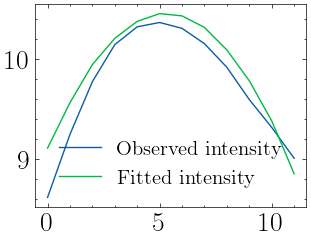

In [20]:
plt.plot(np.log(intensity), label = "Observed intensity")
plt.plot(pred_intensity_log, label = "Fitted intensity")
# plt.fill_between(np.arange(0, len(pred_intensity_log)), y1 = pred_intensity_log - )
plt.legend()

<!-- Parfait, nous avons nos valeurs physiques optimales. Maintenant, propageons les incertitudes sur notre profil Gaussien pour obtenir une incertitude sur les prédictions de notre modèle. 
$$
\begin{align}
\sigma_{I_{m}}^2 = \sigma_{I}^2 + \left(\frac{\partial I}{\partial I_{0}}\right)^2 \sigma_{I_{0}}^2+\left(\frac{\partial I}{\partial \lambda_{0}}\right)^2 \sigma_{\lambda_{0}}^2
+ 
\left(\frac{\partial I}{\partial \lambda}\right)^2 \sigma_{\lambda}^2
+ 
\left(\frac{\partial I}{\partial w}\right)^2 \sigma_{w}^2
\end{align}
$$

... Ça fait beaucoup.
Allons-y: 
$$
\begin{align}
\frac{\partial I}{\partial I_{0}} &= \exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial \lambda} &= \frac{I_{0}}{w^2}(\lambda - \lambda_0)\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial \lambda_{0}} &= \frac{I_{0}}{w^2}(\lambda - \lambda_0)\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial w^2} &= \frac{I_{0}}{2w^4}(\lambda - \lambda_0)^2\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\end{align}
$$ -->

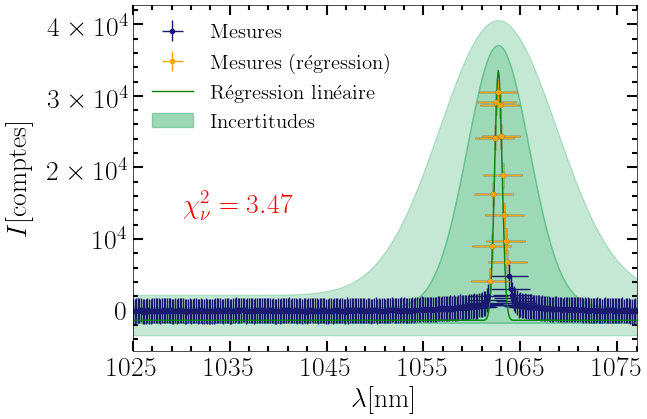

In [109]:
wavelength_fit = np.linspace(wavelength.min()-500, wavelength.max()+500, int(1e4))


fig, axs = plt.subplots(1, 1, figsize = (6.5, 4.5))
ax = axs
sigma_wavelength = 2
ax.errorbar(x = wavelength_full, y = intensity_full-offset, fmt = ".", xerr=sigma_wavelength, yerr=sigma_intensity, label = "Mesures", color = "midnightblue")
ax.errorbar(x = wavelength, y = intensity-offset, fmt = ".", xerr=sigma_wavelength, yerr=sigma_intensity, label = "Mesures (régression)", color = "orange")
intensity_prediction = gaussian_profile(wavelength_fit, *phys_fitted)-offset
# intensity_min_x =  gaussian_profile(wavelength_fit, phys_fitted[0], wavelength_center = phys_fitted[1]-k*sigma_wavelength, width = phys_fitted[2])
ax.plot(wavelength_fit, intensity_prediction, label = "Régression linéaire", color = "green")

k = 1
intensity_max_x =  gaussian_profile(wavelength_fit, phys_fitted[0] + k* sigma_intensity, wavelength_center = phys_fitted[1], width = phys_fitted[2] + k* sigma_wavelength) + k*sigma_intensity - offset
ax.fill_between(wavelength_fit, 
                 -k * sigma_intensity * np.ones_like(intensity_max_x),  
                 intensity_max_x, 
                 color='mediumseagreen', 
                 label = "Incertitudes",
                 alpha=0.5)

k = 2
intensity_max_x2 =  gaussian_profile(wavelength_fit, phys_fitted[0] + k* sigma_intensity, wavelength_center = phys_fitted[1], width = phys_fitted[2] + k* sigma_wavelength) + k*sigma_intensity - offset
ax.fill_between(wavelength_fit, 
                 intensity_max_x,  
                 intensity_max_x2, 
                 color='mediumseagreen', 
                 alpha=0.3)

ax.fill_between(wavelength_fit, 
                 -sigma_intensity * np.ones_like(intensity_max_x),  
                 -k * sigma_intensity * np.ones_like(intensity_max_x), 
                 color='mediumseagreen', 
                 alpha=0.3)

xmin = 1025
xmax = 1077
x_ticks = np.arange(xmin, xmax+1, 10, dtype=np.int16)
x_tick_labels = x_ticks
y_ticks = np.arange(0, 40001, 10000)
y_tick_labels = [r"$0$", r"$10^4$", r"$2\times 10^4$", r"$3 \times 10^4$", r"$4 \times 10^4$"]
ax.xaxis.set_ticks(x_ticks)
ax.xaxis.set_ticklabels(x_tick_labels)
ax.yaxis.set_ticks(y_ticks)
ax.yaxis.set_ticklabels(y_tick_labels)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.1, 0.4), xycoords = 'axes fraction', color = 'r', fontsize = 20)
ax.set(xlabel = r"$\lambda$[nm]", xlim = (xmin, xmax))
ax.set_ylabel(ylabel = r"$I$[comptes]", labelpad=10)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 3,0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left")
# ax.legend()
plt.savefig(os.path.join(figure_folder, 'figure_width_temp.pdf'), bbox_inches = 'tight')


In [90]:
2 * sigma_intensity

np.float64(3479.241283951302)

(1040.0, 1070.0)

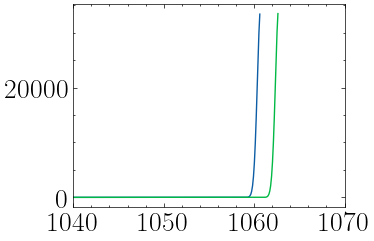

In [42]:
plt.plot(wavelength_fit[:intensity_min_x.argmax()], intensity_min_x[:intensity_min_x.argmax()])
plt.plot(wavelength_fit[:intensity_prediction.argmax()], intensity_prediction[:intensity_prediction.argmax()])
plt.xlim([xmin, xmax])

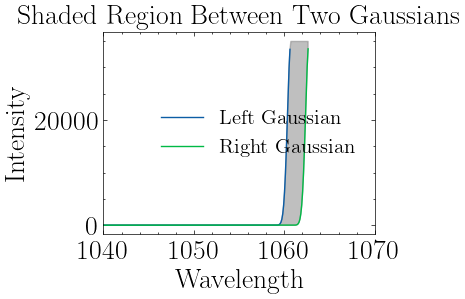

In [67]:
# Plot the two curves
plt.plot(wavelength_fit[:intensity_min_x.argmax()], intensity_min_x[:intensity_min_x.argmax()], label='Left Gaussian')
plt.plot(wavelength_fit[:intensity_prediction.argmax()], intensity_prediction[:intensity_prediction.argmax()], label='Right Gaussian')
len1 = len(intensity_min_x[:intensity_min_x.argmax()])
len2 = len(intensity_prediction[:intensity_prediction.argmax()])
new_x = wavelength_fit[:intensity_prediction.argmax()]
new_min = np.concatenate([intensity_min_x[:intensity_min_x.argmax()], phys_fitted[0]*np.ones(shape = (len2-len1))])
# Define the common x-values range for filling between the curves
# common_x = wavelength_fit[:min(intensity_min_x.argmax(), intensity_prediction.argmax())]

# Fill the area between the two curves
plt.fill_between(new_x, 
                 new_min, 
                 intensity_prediction[:intensity_prediction.argmax()], 
                 color='gray', alpha=0.5)

# Set x limits
plt.xlim([xmin, xmax])

# Optional: Add labels, title, legend
plt.legend()
plt.title('Shaded Region Between Two Gaussians')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

plt.show()


In [66]:
intensity_min_x[:x.argmax()].shape

(17,)

In [64]:
new_x.shape

(4999,)

In [65]:
new_min.shape

(37,)

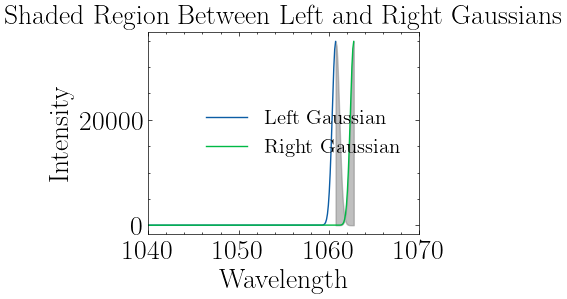

In [48]:
# Find the x-values at the peaks of both curves
left_peak_index = intensity_min_x.argmax()  # Index of the peak on the left Gaussian
right_peak_index = intensity_prediction.argmax()  # Index of the peak on the right Gaussian

# Plot the two curves
plt.plot(wavelength_fit[:left_peak_index+1], intensity_min_x[:left_peak_index+1], label='Left Gaussian')
plt.plot(wavelength_fit[:right_peak_index+1], intensity_prediction[:right_peak_index+1], label='Right Gaussian')

# Define the x-values range for filling between the peaks of the two curves
common_x = wavelength_fit[left_peak_index:right_peak_index+1]

# Fill the area between the two curves in this range
plt.fill_between(common_x, 
                 intensity_min_x[left_peak_index:left_peak_index+len(common_x)], 
                 intensity_prediction[left_peak_index:left_peak_index+len(common_x)], 
                 color='gray', alpha=0.5)

# Set x limits
plt.xlim([xmin, xmax])

# Optional: Add labels, title, legend
plt.legend()
plt.title('Shaded Region Between Left and Right Gaussians')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

plt.show()


In [50]:
# Define the y-values (intensity) that cover both curves
common_y = np.minimum(intensity_min_x[:left_peak_index+1], intensity_prediction[:right_peak_index+1])

# Plot the two curves
plt.plot(wavelength_fit[:left_peak_index+1], intensity_min_x[:left_peak_index+1], label='Left Gaussian', color='blue')
plt.plot(wavelength_fit[:right_peak_index+1], intensity_prediction[:right_peak_index+1], label='Right Gaussian', color='green')

# Fill the area between the two curves horizontally (along the y-axis)
plt.fill_betweenx(common_y, 
                  wavelength_fit[:left_peak_index+1], 
                  wavelength_fit[:right_peak_index+1], 
                  color='gray', alpha=0.5)

# Set limits and labels
plt.xlim([xmin, xmax])
plt.ylim([0, max(np.max(intensity_min_x), np.max(intensity_prediction))])

# Optional: Add labels, title, legend
plt.legend()
plt.title('Shaded Region Between Left and Right Gaussians')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

plt.show()


ValueError: operands could not be broadcast together with shapes (4980,) (5000,) 

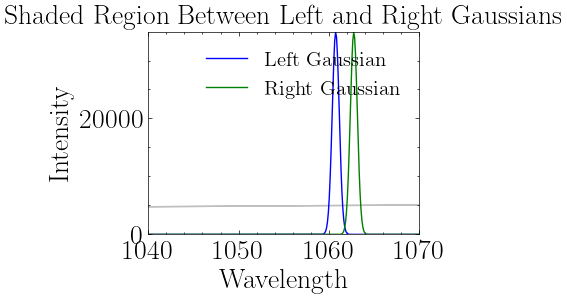

In [51]:
# Find the smaller size between the two arrays to ensure they have the same length
min_len = min(len(intensity_min_x), len(intensity_prediction))

# Slice both arrays to the minimum length
intensity_min_x_slice = intensity_min_x[:min_len]
intensity_prediction_slice = intensity_prediction[:min_len]
wavelength_fit_slice = wavelength_fit[:min_len]

# Plot the two curves
plt.plot(wavelength_fit_slice, intensity_min_x_slice, label='Left Gaussian', color='blue')
plt.plot(wavelength_fit_slice, intensity_prediction_slice, label='Right Gaussian', color='green')

# Fill the area between the two curves horizontally (along the y-axis)
plt.fill_betweenx(np.arange(0, len(intensity_min_x_slice)),  # Y-values
                  wavelength_fit_slice,  # Left Gaussian x-values
                  wavelength_fit_slice,  # Right Gaussian x-values
                  color='gray', alpha=0.5)

# Set limits and labels
plt.xlim([xmin, xmax])
plt.ylim([0, max(np.max(intensity_min_x), np.max(intensity_prediction))])

# Optional: Add labels, title, legend
plt.legend()
plt.title('Shaded Region Between Left and Right Gaussians')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

plt.show()
